In [322]:
# generate CoxPH model data
import numpy as np
import numpy.random as rd


def make_phaz_data(n, coef,rho=0.3,lam = 10, time=3, seq=10):
    p = coef.shape[0]
    mu = np.zeros(p)
    # interval
    #a = np.random.uniform(0,time, seq)
    #a=np.append(np.array(0), np.sort(a))
    #a=np.append(a,time)
    a=np.linspace(0,time,seq)
    #print(a)

    L = np.zeros(n)   # left of the censoring intervals
    R = np.zeros(n)   # right of the censoring intervals
    Sigma = np.power(rho, np.abs(np.linspace(1, p, p) - np.linspace(1, p, p).reshape(p, 1)))
    x = rd.multivariate_normal(mu, Sigma, (n,))    # variables
    xcoef = np.matmul(x,coef)
    #print(np.max(xcoef))
    T = -np.log(rd.uniform(0,1, (n,)))/(lam*np.exp(xcoef))   # survival time
    #print(T)
    print("The maximum survival time of the sample is:", np.max(T))
    if(np.max(T)>time):
        print("The observation time is too short, please change a larger time")
        return(0)
    else:
        for i in range(n):
            index = np.where((a>T[i]))[0][0]
            #print(index)
            L[i] = a[index-1]
            R[i] = a[index]
        return x, L, R

In [307]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

def phazard_objective(params):
    xcoef = jnp.matmul(x, params)
    #print(xcoef)
    #print(jnp.exp(xcoef))
    #print(jnp.exp(-lam*jnp.multiply(L,jnp.exp(xcoef)))-jnp.exp(-lam*jnp.multiply(R,jnp.exp(xcoef))))
    return -jnp.sum(jnp.log( jnp.exp(-lam*jnp.multiply(L,jnp.exp(xcoef)))-jnp.exp(-lam*jnp.multiply(R,jnp.exp(xcoef)) )))/n

The maximum survival time of the sample is: 5.207315063716993
0.98989898989899


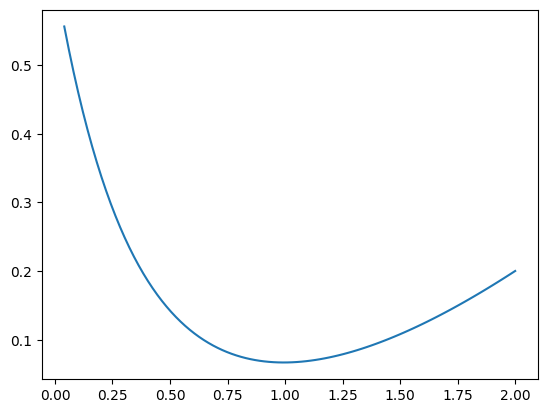

In [327]:
# generate data 
n, p, k, lam = 200, 1, 1, 20
np.random.seed(1234)
beta = np.zeros(p)
beta[np.linspace(0, p - 1, k, dtype=int)] = [1 for _ in range(k)]
x, L, R = make_phaz_data(n,beta,lam=20,time=10,seq=20)

# plot
coef = np.linspace(0,2,100)
y = np.zeros_like(coef)
for i in range(len(y)):
    y[i] = phazard_objective(np.array([coef[i]]))
plt.plot(coef,y)
print(coef[np.argmin(y)])

The maximum survival time of the sample is: 2.9026378385145004
[1. 0.]


C:\Users\user\AppData\Local\Temp\ipykernel_13828\545209127.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter3D(xlab,ylab,zlab, cmap='Blues')


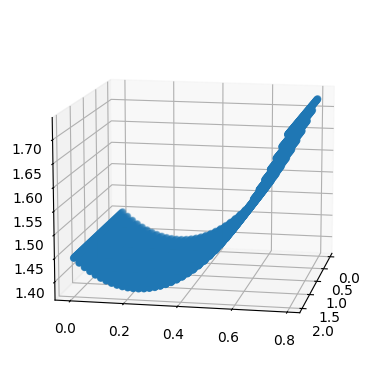

12

In [331]:
# generate data 
n, p, k, lam = 200, 2, 1, 20

np.random.seed(1234)
beta = np.zeros(p)
beta[np.linspace(0, p - 1, k, dtype=int)] = [1 for _ in range(k)]
x, L, R = make_phaz_data(n,beta,lam=10, time=5,seq=10)


# plot
import matplotlib.pyplot as plt
print(beta)
xlab = np.repeat(np.linspace(0,2,100),100)
ylab = np.tile(np.linspace(0,2,100),100)
zlab = np.zeros_like(xlab)
for i in range(100):
    for j in range(100):
        #print(np.array([xlab[i],ylab[j]]))
        zlab[100*i+j] = phazard_objective(np.array([xlab[i],ylab[j]]))
fig = plt.figure()
ax1 = plt.axes(projection='3d')
ax1.scatter3D(xlab,ylab,zlab, cmap='Blues')
ax1.view_init(elev=12, azim=11)
plt.show()

np.argmin(zlab)

In [334]:
from scope import ScopeSolver

solver = ScopeSolver(p, k)
solver.solve(phazard_objective, jit=True, init_params = np.ones(p)/2)

#print("Estimated parameter:", solver.get_result()["params"], "objective:",solver.get_result()["value_of_objective"])
print("Estimated parameter:", solver.get_result()["params"], "objective:",solver.get_result()["value_of_objective"])
print("True parameter:", beta, "objective:",phazard_objective(beta))


Estimated parameter: [0.         0.23518718] objective: 1.385486364364624
True parameter: [1. 0.] objective: 0.3636248


In [342]:
from scope import ScopeSolver

# generate data 
n, p, k = 200, 2, 1

np.random.seed(1234)
beta = np.zeros(p)
beta[np.linspace(0, p - 1, k, dtype=int)] = [1 for _ in range(k)]
x, L, R = make_phaz_data(n,beta,lam=10,time=5,seq=10)


solver = ScopeSolver(p, k)
solver.solve(phazard_objective, jit=True, init_params=np.ones(p))

#print("Estimated parameter:", solver.get_result()["params"], "objective:",solver.get_result()["value_of_objective"])
print("Estimated parameter:", solver.get_result()["params"], "objective:",solver.get_result()["value_of_objective"])
print("True parameter:", beta, "objective:",phazard_objective(beta))


The maximum survival time of the sample is: 2.9026378385145004
Estimated parameter: [1.66311704 0.        ] objective: 0.261320561170578
True parameter: [1. 0.] objective: 0.3636248
